# COGS 108 - Final Project

# Overview
In this final project of Data science, we are trying to generate a recommendation system of movies for IMDB users with the respect of their historical ratings. At first, after obtaining the datasets about both film's final ratings and individual users' ratings, we would try to combine them together with movieID as the key for further comparisons. Next, by visualizing the collected data, we would study the correlation between individual as well as final ratings of films and film genres. At last, we would use the model we generate to recommend films for each individual user. 

# Names
- Anthony Ostia
- Ramin Atrian
- Chuyang Xiao
- Yifeng Zhang
- Ian Nelson

# Group Members IDs
- A13903305
- A15691021
- A13722916
- A13820262
- A15738482

# Research Question
How to recommend films in their favorite genres to each individual IMDB user according to their historical ratings?

# Background 
Since the beginning of the 20th century, film has been an important recreation to human beings possessing both artistic and commercial significance. Moreover, in the Information Age, rather than being overwhelmed by the gigantic informative flow, film won unprecedented attention from the population with the aid of widespread accessibility to the Internet. Just like Hsu (2014) argued in his essay, in the era of Web 2.0, film critics are no longer privileges limited to professionals yet typical rights to common audiences as well, due to the introduction of film rating websites such as IMDB or Rotten Tomatoes: each audience could comment or grade films online and then share their evaluations and opinions to the public. Consequently, the data collected thereby is not only abundant in quantity, but also diverse in nature, including millions of users’ personal information as well as preference of films. Hence, considering it a perfect dataset to study users’ attributes to films, we would like to focus on the ratings on movie websites in this project.

As increasing audiences begin to consider online ratings as critical criteria to decide whether or  not to see a film, a number of data scientists struggle to explore the rating data, which has provided us with the direction of further research. In the research accomplished by Hsu (2014) focusing on predicting the movies user rating based on the IMDB attributes, by analyzing the ratings and critics of 31506 movies, they generated a mathematical model mimicking the manners of the preference of general IMDB users, and hence predicted the final rating of a newly coming movie via entering related parameters to it. Regardingly, we found that instead of being purely independent, the IMDB ratings of new films could be roughly predicted by past data. Furthermore, in Breuss’s research (2012), the personal information on users’ social media, including gender, hobby, or regular activities, was taken into account and therefore, predicted the IMDB movie ratings they might give, which inspires that individuals’ statistics could also be of concern. 

All in all, in this data science project, we will combine these two studies and step forward: we will study what kind of movies will a user like based on the historical ratings and review texts of that user on movies he/she has seen previously. From our perspective, this study is not only interesting but also quite applicable, could possibly promote the recommendation system in movie rating websites.

Reference:
1. Hsu, P. Y., Shen, Y. H., & Xie, X. A. (2014, October). Predicting movies user ratings with imdb attributes. In International Conference on Rough Sets and Knowledge Technology (pp. 444-453). Springer, Cham.
2. Oghina, A., Breuss, M., Tsagkias, M., & De Rijke, M. (2012, April). Predicting imdb movie ratings using social media. In European Conference on Information Retrieval (pp. 503-507). Springer, Berlin, Heidelberg.

# Hypothesis
Within this data science group project, we would like to develope a recommendation systems for the movie rating websites which involves to predict the users' preference in movie according to their rating history and then provide them with certain genre of movies that they favour. Hence, we generated a couple of hypothesises with the respect of this topic:
1. With the respect of the users, one would like to rate higher on the genres (higher than the average) he or she loves, which indicates his or her love. On the opposite, to the genres he or she dislikes, his or hers ratings would be much lower(lower than or equal to the average).
2. Moreover, if a user loves a certain genre of film, he or she tends to watch more this genre of films.
3. If a user loves a certain genre of film, this genre of film must exist among the films he or she rates the highest

# Datasets

Data on ratings comes from
https://www.kaggle.com/rounakbanik/the-movies-dataset/version/7#

This dataset contains over 200000000 ratings from 138493 users, containing the movieID they rates, the scores they give to each film, and the timestamps of the ratings.

Data about movies comes from
https://www.kaggle.com/grouplens/movielens-20m-dataset#tag.csv

This data contains the information of 27277 movies, including their movieID, title and genres.

# Setup
First and foremost, we would import the useful modules and packages.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Then, we would load in our datasets in csv with pandas method.

In [2]:
df_rating = pd.read_csv('rating.csv') 

In [3]:
df_rating

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
5,1,1968,4.0,1425942148
6,1,2762,4.5,1425941300
7,1,2918,5.0,1425941593
8,1,2959,4.0,1425941601
9,1,4226,4.0,1425942228


In [4]:
df_movie = pd.read_csv('movie.csv',dtype = {'title':str, 'genres':str, 'movieId':int})

In [5]:
df_movie

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy
5,6,Heat,Action|Crime|Thriller
6,7,Sabrina,Comedy|Romance
7,8,Tom and Huck,Adventure|Children
8,9,Sudden Death,Action
9,10,GoldenEye,Action|Adventure|Thriller


# Data Cleaning
First and foremost, before actually executing the data, we shall check the cleanness of the dataset we get. To begin with, we would clear and standardize the rating dataset.

Next, for the rating dataset, we would only keep three columns and remove the rest:
1. the userID (an integer)
2. the movieID of the movies they rate (an integer)
3. the scores users give to movies (a float)

In [6]:
df_rating = df_rating.drop(columns = ['timestamp'])

For the movie dataset, we shall firstly standardize it into three columns
1. the movieID (an integer)
2. the movie title (a string)
3. the movie genre (list)

In [7]:
df_movie

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy
5,6,Heat,Action|Crime|Thriller
6,7,Sabrina,Comedy|Romance
7,8,Tom and Huck,Adventure|Children
8,9,Sudden Death,Action
9,10,GoldenEye,Action|Adventure|Thriller


Then, we shall check whether there are missing data in both datasets.
We check whether there are missing movieID, genre, movie title or IMDB average ratings in the movie datasets. If so, just remove such rows.

In [8]:
rating_to_drop = df_rating[df_rating.isnull().any(axis=1)]
movie_to_drop = df_movie[df_movie.isnull().any(axis=1)]

In [9]:
print(rating_to_drop)
print(movie_to_drop)

Empty DataFrame
Columns: [userId, movieId, rating]
Index: []
Empty DataFrame
Columns: [movieId, title, genres]
Index: []


Afterwards, some pre-processings are needed. To facilitate further visulizations, we may need to convert the original rating in the scale of 5 into the rating in the scale of 10.

In [10]:
# we change the rating from a scale of 5 to a scale of 10
df_rating['rating'] *= 2

Then, since the original ratings dataset is so large and we may not need such redundant data, in further predictive models, we would like to select smaller samples from it. Therefore, considering the users' behaviors would be consistent overall the rating dataframe, we create two subgroups from the original ratings data, one is for training and the other is for testing, in order to represent the general rating dataframe.

In [11]:
train = df_rating[df_rating['userId']<=2000]
# we would select the first 2000 users as our training set

Then, check whether following conditions appear in the rating datasets:
1. missing ratings
2. ratings on films whose movieID does not exist in the movie dataset(since we are going to link the movie and rating dataset with the movieID)
if such problems exist, please remove the problematic rating (but not the rest of the users' rating)

In [12]:
# drop the rows with missing movieIDs
rows_to_drop = []
for n in range(len(train)):
    if train['movieId'][n] not in df_movie['movieId']:
        rows_to_drop.append(n)

In [13]:
train = train.drop(rows_to_drop)

In [14]:
frames = [train[train['userId'] == i+1][-5:] for i in range(2000)]

In [15]:
test = pd.concat(frames)

In [16]:
todrop = test.index.values

In [17]:
train = train.drop(todrop)

Finally, we create a new column in the train dataframe called: average_score, and use the movieID as a reference to append the average rating after the user's rating.

In [18]:
# since we do not have the average rating of each film in our dataset, we would need to calculate them by ourselves,
# and then append the calculated average ratings to the train dataframe

In [ ]:
# calculate the average score of each movie based on the data in the rating dataset
average_ratings = []
for i in df_movie['movieId']:
    sum_rates = 0
    average = 0
    for r in df_rating[df_rating['movieId'] == i]['rating']:
        sum_rates += r
    average = sum_rates / (len(df_rating[df_rating['movieId'] == i])+1)
    average_ratings.append(average)
df_movie['average_rating'] = average_ratings

In [ ]:
df_movie.to_csv('moviedata.csv', encoding='utf-8', index=False)

# READ THIS PART!!! To save time

In [19]:
df_movie = pd.read_csv('moviedata.csv')

In [20]:
df_movie

,movieId,title,genres,average_rating
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7.842321
1,2,Jumanji,Adventure|Children|Fantasy,6.423665
2,3,Grumpier Old Men,Comedy|Romance,6.301586
3,4,Waiting to Exhale,Comedy|Drama|Romance,5.720711
4,5,Father of the Bride Part II,Comedy,6.128679
5,6,Heat,Action|Crime|Thriller,7.669540
6,7,Sabrina,Comedy|Romance,6.732449
7,8,Tom and Huck,Adventure|Children,6.279661
8,9,Sudden Death,Action,6.008331
9,10,GoldenEye,Action|Adventure|Thriller,6.859822


In [29]:
average_ratings = []
for i in train['movieId']:
    average = 0
    for r in df_movie[df_movie['movieId'] == i]['average_rating']:
        average = r
    average_ratings.append(average)
train['average_score'] = average_ratings

KeyboardInterrupt: 

In [ ]:
train

Same as the previous step, also append the genre of each rated film in the train dataframe as a new column called genre.

In [ ]:
genre = []
for i in train['movieId']:
    g = ""
    for val in df_movie[df_movie['movieId'] == i]['genres']:
        g = val
    genre.append(g)
train['genres'] = genre

Afterwards, create a new column called variance, to store the variance between the user's rating and average rating.

For instance, if in one row of the train dataframe, one user gives 8 to a film while the film is indeed 6.4, the variance in that row would be 1.6. And if the user gives a 5 to a film while the films is indeed 8.1, the variance would be -3.1.

In [ ]:
variances = []
for n in range(len(train)):
    usr_rate = train['rating'].iloc[n]
    avr_rate = train['average_score'].iloc[n]
    v = usr_rate - avr_rate
    variances.append(v)
train['variance'] = variances

In [ ]:
train

In [ ]:
train.to_csv('train.csv', encoding='utf-8', index=False)

# Also Read this!!!

In [21]:
train = pd.read_csv('train.csv')

At this point, the train dataframe would have these columns for each rating:
1. userID (an integer)
2. movieID (an integer)
3. user's rating (an integer)
4. average rating (a float)
5. the genres of the film they rate (a list)
6. the variance (a float)

In [22]:
train

,userId,movieId,rating,average_score,genres,variance
0,1,2,7.0,6.423665,Adventure|Children|Fantasy,0.576335
1,1,29,7.0,7.903532,Adventure|Drama|Fantasy|Mystery|Sci-Fi,-0.903532
2,1,32,7.0,7.795936,Mystery|Sci-Fi|Thriller,-0.795936
3,1,47,7.0,8.106798,Mystery|Thriller,-1.106798
4,1,50,7.0,8.668560,Crime|Mystery|Thriller,-1.668560
5,1,112,7.0,6.824573,Action|Adventure|Comedy|Crime,0.175427
6,1,151,8.0,7.077514,Action|Drama|Romance|War,0.922486
7,1,223,8.0,7.738774,Comedy,0.261226
8,1,253,8.0,6.993036,Drama|Horror,1.006964
9,1,260,8.0,8.381190,Action|Adventure|Sci-Fi,-0.381190


Then, for our test dataframe, do the same thing to the test dataframe and make it have the six columns for further usages.

In [23]:
average_ratings1 = []

for it1 in test['movieId']:
    sum_rates1 = 0
    average1 = 0
    for it2 in test[test['movieId'] == it1]['rating']:
        sum_rates1 += it2
    average1 = sum_rates1 / len(test[test['movieId'] == it1])
    average_ratings1.append(average1)
test['average_score'] = average_ratings1

In [24]:
genre = []
types = ''

for it1 in test['movieId']:
    for it2 in df_movie[df_movie['movieId'] == it1]['genres']:
        types = it2
    genre.append(types)
test['genres'] = genre

In [25]:
variances = []

for it1 in range(len(test)):
    usr_rate1 = test['rating'].iloc[it1]
    avr_rate1 = test['average_score'].iloc[it1]
    difference = usr_rate1 - avr_rate1
    variances.append(difference)
test['variance'] = variances

# Data Analysis & Results

# Data Visualization

##   Graph 1: The Average Rating of Each Genre in the Movie Dataframe

Utilizing the average-rating column in the df_movie dataset, create a bar graph to show the average rating of each genre.

In [26]:
# code here

Evaluation: 

## Graph 2: The Average Rating of Each Genre in the Train Dataframe

for each type of film that appears in the movie dataframe. If one film has more than one genre, please assume it belongs to all these genres.

Then, use the numpy.mean() method to calculate the average ratings of each genre of films. Then create a bar graph about this with:
1. x-axis: the film genres
2. y-axis: the average ratings

(if you have some better methods, please try so!)

In [27]:
score_dict = {}
for index, row in train.iterrows():
    genres = row[4].split('|')
    for gen in genres:
        if gen in score_dict:
            score_dict[gen].append(row[3])
        else:
            score_dict[gen] = [row[3]]

In [28]:
average_dict = {}
for key,value in score_dict.items():
    average_dict[key] = sum(value)/len(value)

In [29]:
genres = []
scores = []
for key, value in average_dict.items():
    genres.append(key)
    scores.append(value)

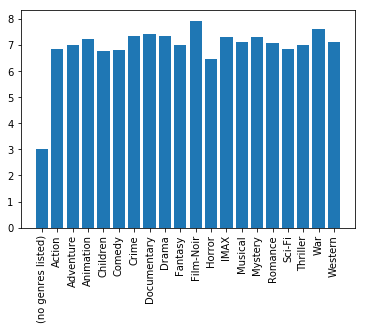

In [30]:
plt.bar(genres, height= scores)
plt.rcParams["figure.figsize"] = [50, 10]
plt.xticks(rotation=90)
plt.show()

##### Evaluation:

Consisting with this graph, we could obtain some information about the train dataset we are going to deal with in the coming sections. First and foremost, we could see in the train dataframe, there is no significant variance in the average ratings between the genres within the train dataset, with all their average ratings concentrating around 7 with few spreading in the range between 7 and 8.

Moreover, if we focus on the average rating of each genre, we could see that among the 2000 users we selected, the film noir tends to have the highest average ratings (about 8.4). Moreover, the horror films tend to have the lowest average ratings (about 6.5).

From this graph, we could also learn that compare with the graph about the overall movie ratings:

## Graph 3: The Number of Films in Each Genre

Please create a bar chart, using df_movie as the data, to represent the number of film in each genre

In [31]:
# code here

Evaluation:

## Graph 4: The Number of Films that Users in Train Dataframe Rate

Afterwards, we would still stick to the train dataframe. Since one of our predictive factor would be the number of films each user has rated, we may show the distribution of number of films users view.

Then we would also create a dictionary, with userID as the key, and if the user with ID = 5 rates totally 10 films, the key would be 5 and the value would be 10. With this dictionary, we could then generate a histogram about the distribution of the # of film users watches.

1. x - axis: the number of films viewed (0~10, 10~20, 20~30 .......)
2. y - axis: the number of users viewed that number of films

In [32]:
films_dict = {}
for index, row in train.iterrows():
    key = row['userId'] 
    old_value = films_dict.get(key)
    
    if old_value == None:
        films_dict[key] = 1
        a = 1
    else:
        a = a + 1
        films_dict[key] = a

(array([ 402.,  216.,  173.,  123.,  109.,  113.,   76.,   72.,   52.,
          45.,   53.,   35.,   28.,   29.,   25.,   20.,   33.,   19.,
          17.,   18.,   24.,   10.,   14.,   14.,   16.,   10.,   11.,
          11.,   10.,    9.,    8.,    9.,    9.,    4.,    5.,   10.,
           6.,    5.,    4.,   12.,    3.,    3.,    5.,    7.,    3.,
           6.,    9.,    5.,    1.,    3.,    3.,    4.,    1.,    1.,
           5.,    2.,    3.,    2.,    2.,    1.,    1.,    4.,    3.,
           1.,    1.,    0.,    3.,    3.,    3.,    2.,    0.,    3.,
           1.,    2.,    2.,    1.,    2.,    1.,    0.,    1.,    0.,
           1.,    1.,    1.,    0.,    1.,    1.,    0.,    2.,    0.,
           1.,    1.,    0.,    1.,    2.,    0.,    1.,    0.,    1.,
           1.,    0.,    2.,    0.,    1.,    0.,    1.,    1.,    0.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.,    2.,    1.,
           0.,    0.,    0.,    0.,    1.,    1.,    1.,    0.,    0.,
      

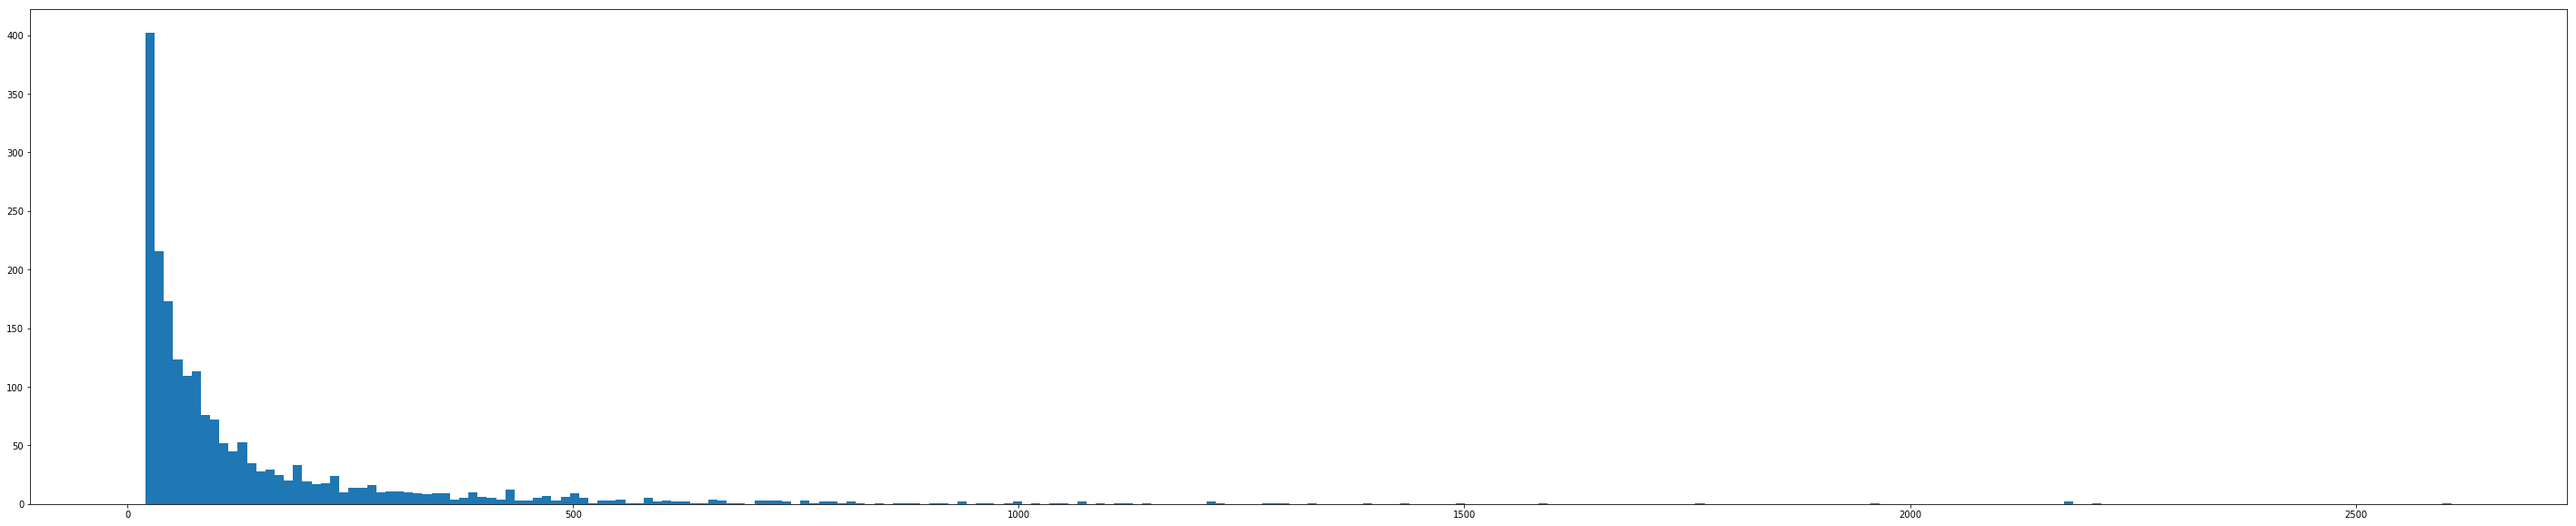

In [33]:
plt.hist(films_dict.values(), bins = 250)

the evaluation of this graph:

Chuyang would write this part

# Graph 4

The fourth graph would still stick to the train dataset. This time we would do something pretty similar to the graph one, which displays the average rating of each genre in the train dataframe we select. We would then use it to compare with the graph 1 to show the consistency of the data in the sample we select

In [34]:
# code here
# Ian please write this part

the evaluation of the graph 4:

Chuyang would write this part

# Graph 5 

This graph would focus on the variance column in the train dataframe. This time, we would create a bar graph representing the variance in each genre of film, in order to see the range of variance for each genre of film.
1. x - axis: the genres
2. y - axis: the variance of ratings of each genre of films

Hence, we could see how each genre of film has its scores spreads out.

In [59]:
variances_dict = {}
for index, row in train.iterrows():
    key = row['genres']
    value = variances_dict.get(key)
    if value == None:
        variances_dict[key] = row['variance']

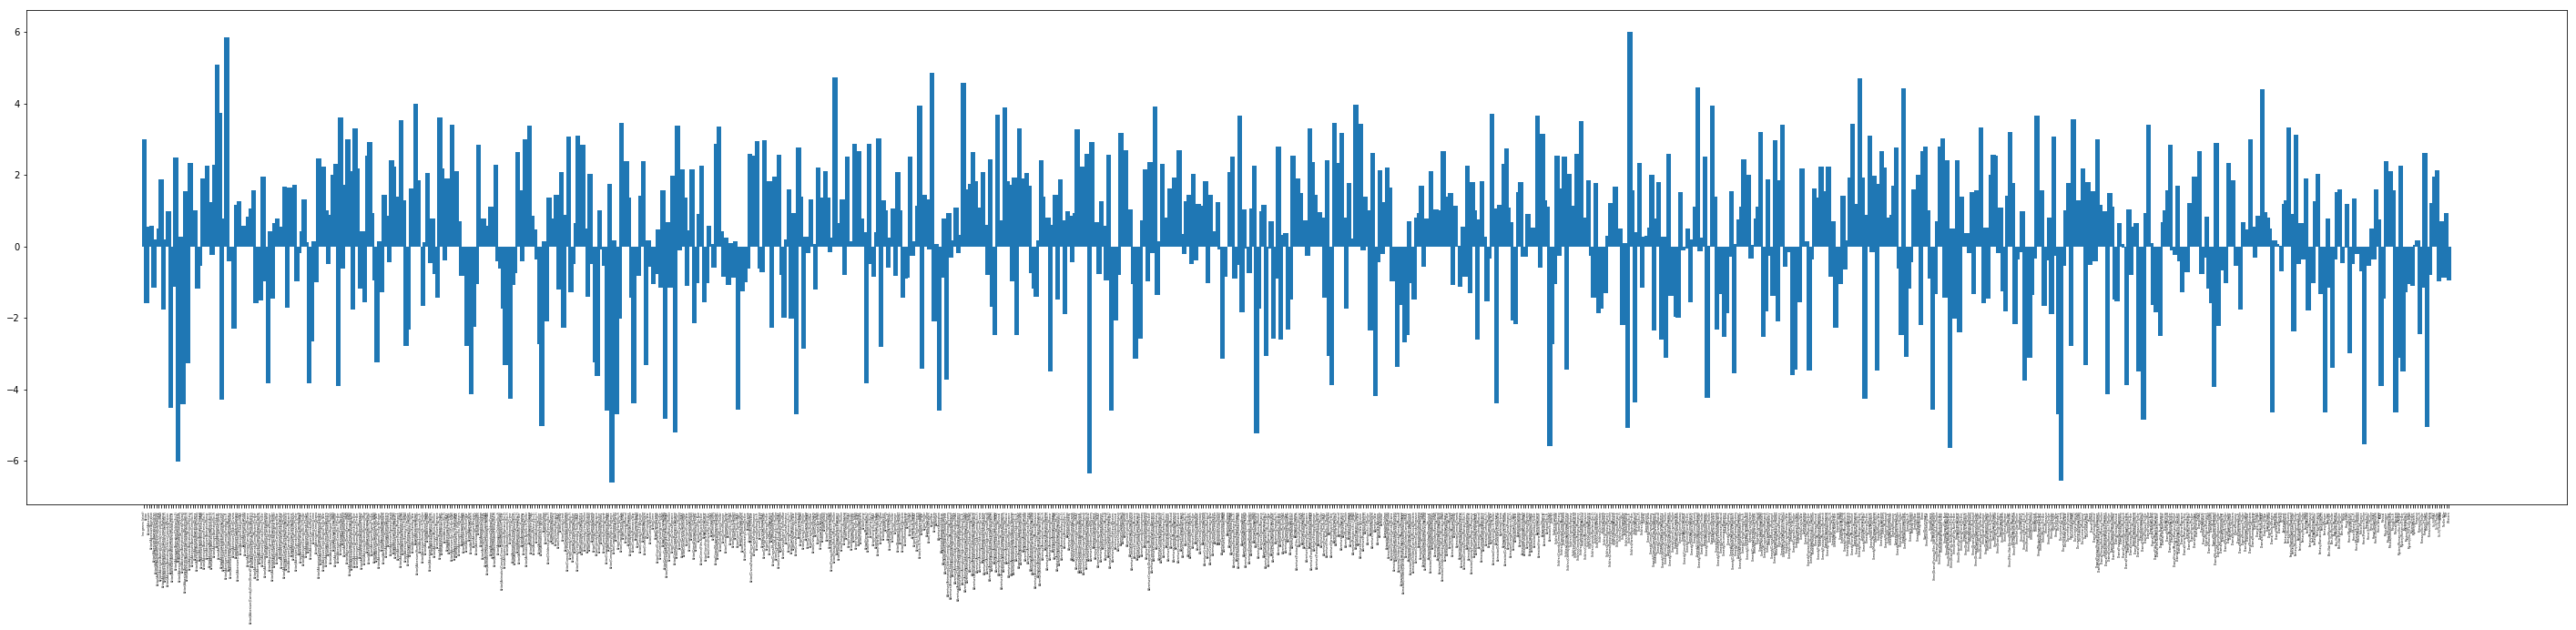

In [62]:
genres = []
variances = []
for key, value in variances_dict.items():
    genres.append(key)
    variances.append(value)
plt.bar(genres, height=variances, width=2)
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=3)
plt.show()

The evaluation of graph 5:

Chuyang would write this part

# Ethics and Privacy

# Conclusion and Discussion